В данном ноутбуке рассматривалась задача сопоставления сходства тем модели тематического моделирования из `текстов базы авторефератор из раздела "результаты"` и `областей исследования` из [паспорта специальностей научных работников, 14.00.21 "Стоматология"](http://www.aspirantura.spb.ru/pasp/14_0_21.html)

Так как областей исследования 6, то и тем так же было выделено 6 (далее)

**Терминология**

* Тема - набор терминов, которые описывают какой-то объект
* Таргет - целевая переменная (в данном случае "области исследования" для каждого текста)
* Предсказание - искомая переменная (в данном случае это темы модели тематического моделирования)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from helper_functions import *

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
import numpy as np
import artm
from collections import defaultdict

In [5]:
import json

with open('saved_content/metadata.json') as fh:
    metadata = json.load(fh)
    
codes, years = metadata['codes'], metadata['years']

# загрузка отфильтрованных данных
with open('saved_content/procced_texts_tfidf_filtered_vocab.json') as fh:
    tokens_filtered = json.load(fh)

In [6]:
print(f'Данная выборка содержит {len(tokens_filtered)} текстов')

Данная выборка содержит 2167 текстов


В данном случае рассматриваются только тексты, содержащие код специальности `14.00.21 Стоматология`

# Тематическое моделирование

Используем фреймворк [BigARTM](http://www.machinelearning.ru/wiki/index.php?title=BigARTM)

In [7]:
!rm -rf batches
!rm -f cv_wabbit*.vw vocab.txt

In [8]:
@check_path
def vocabulary_prep(text, vocab):
     with open(vocab, 'w') as fh:
        for sent in text:
            fh.write(' |text ' + sent + '\n')

In [9]:
# для всех текстов сразу
cv_vocab_path = 'cv_wabbit_v2.vw'
vocabulary_prep([' '.join(text) for text in tokens_filtered], cv_vocab_path)

#### Подготовка бачтей

In [10]:
batch_vectorizer = batching(data_path=cv_vocab_path)

### Create an ARTM dictionary

In [11]:
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

### Save / load dictionary

In [12]:
# !rm -f vocab.txt
dictionary.save_text('vocab_all_texts.txt')
# dictionary.load_text(dictionary_path='vocab_all_texts.txt')

### ARTM model initialization

[пример](https://www.coursera.org/learn/unsupervised-learning/supplement/suSWG/noutbuk-iz-diemonstratsii-ispol-zovaniia-bigartm)

In [13]:
T = 6  # число тем
tokens_per_T = 10 # число токенов в теме
num_collection_passes = 10  # число проходов по коллекции

In [14]:
def init_model_artm(dictionary=dictionary):
    model_artm = artm.ARTM(num_topics=T,
                           topic_names=[str(i + 1) for i in range(T)],
                           class_ids={"text":1},
                           reuse_theta=True, 
                           cache_theta=True,
                           num_document_passes=10,
                           seed=0)
    
    # add scorers
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model_artm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=tokens_per_T, class_id='text'))
    
    model_artm.initialize(dictionary=dictionary)
    return model_artm

# model_artm = init_model_artm(dictionary)

`phi score`: разреженность матрицы распределения терминов в теме

`theta score`: разреженность матрицы распределения тем в документах


$\Phi$: `model_artm.get_phi()`
по столбцам стоят отдельные темы, по строкам - слова в коллекции, значение = P(w|t)

$\Theta$: `model_artm.get_theta()`
по столбцам - документы, по строкам - темы, значение = P(t|d)


### 0. Модель без регуляризаторов

На выходе нас интересуют непосредственно 6 тем. Модель не может дать название темы - их интерпретацию необходимо производить вручную

In [15]:
model_artm = init_model_artm()
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                       num_collection_passes=num_collection_passes)

tokens_printer(model_artm)

show_matrices_sparsity(model_artm)

1: слюнный, болевой, нижнечелюстной, дисфункция, движение, выраженность, тревожность, смещение, физиологический, жевание

2: трансплантат, небо, оперативный, пластика, кровоток, пазуха, верхнечелюстной, реставрация, регенерация, врожденный

3: сахарный, оказание, учреждение, деятельность, деструктивный, детский, современный, стоматология, организация, взрослый

4: флегмона, район, кпу, житель, первичный, доля, характерный, сопра, заболеваемость, повышенный

5: покрытие, каркас, вт, свет, желудок, режим, язвенный, нсо, минута, титановый

6: длина, остеосинтез, ширина, отломок, резец, прочность, вертикальный, плоскость, окклюзионный, цемент

Phi sparsity: 0.471
Theta sparsity: 0.24


## Интерпретация тем

Смотрим на полученные термины из ячейки выше и даем сопоставление из доступных [областей исследования](http://www.aspirantura.spb.ru/pasp/14_0_21.html#:~:text=%D0%9E%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D1%8C%20%D0%B8%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%3A)

1. челюстно-лицевая хирургия (область исследования № 3)
2. врожденные аномалии (область исследования № 4)
3. организация стоматологической помощи (область исследования № 6)
4. челюстно-лицевая хирургия (только "флегмона") -- ?
5. кариес (покрытие, свет, минута) -- ?
6. зубопротезирование (область исследования № 5)

Области исследования (№ 1 кариес и № 2 пародонт) не вошли в темы, полученные нашей моделью

Таким образом, имеем сопоставление для областей исследования № 3, 4, 5 и 6

*Для удобства продублирую "области исследования" здесь*

[Ссылка](http://www.aspirantura.spb.ru/pasp/14_0_21.html)

Область исследования:
1. Изучение этиологии, патогенеза, эпидемиологии, методов профилактики, диагностики и лечения поражений твердых тканей зубов (кариес и др), их осложнений.
2. Изучение этиологии, патогенеза, эпидемиологии, методов профилактики, диагностики и лечения заболеваний пародонта.
3. Изучение проблем хирургической стоматологии с разработкой методов диагностики и лечения заболеваний челюстно-лицевой области.
4. Изучение этиологии и патогенеза врожденных и приобретенных аномалий развития, дефектов и деформаций челюстно-лицевой области.
5. Разработка и обоснование новых клинико-технологических методов в ортодонтии и зубопротезировании.
6. Разработка и совершенствование методов организации и оказания стоматологической помощи населению и развития специальности в новых условиях хозяйствования.

### Вероятности тем в документе i

Посчитаем, с какой вероятностью i-ый документ может относится к каждой j-ой теме (предполагаемой области исследования из паспорта специальности

Сделаем допущение, что документ может принадлежать каждой теме равновероятно с `p = 0.25`

In [16]:
# делаем допущение, что документ может принадлежать

theta = model_artm.get_theta()
TOPIC_PROBA_THRESHOLD = 0.25

In [17]:
# сортировка колонок в таблице по возрастанию
# колонка = id документа в коллекции
theta = theta.reindex(sorted(theta.columns), axis=1)

In [18]:
%%time

doc_index_to_topics_proba = []

for col in theta:
    above_thresh = theta[col][theta[col] > TOPIC_PROBA_THRESHOLD]
    
    # для текстов "без тем" (не прошедших порог)
    if not above_thresh.shape[0]:
        doc_index_to_topics_proba.append([(-1, 0.0)])
        continue

    topic_names = above_thresh.index.tolist()
    topic_probas = above_thresh.tolist()
    
    topics_cur_doc = []
    for name, proba in zip(topic_names, topic_probas):
        topics_cur_doc.append((int(name), proba))
    doc_index_to_topics_proba.append(topics_cur_doc)

CPU times: user 435 ms, sys: 44.7 ms, total: 480 ms
Wall time: 429 ms


### Сопоставление индексов полученных тем и актуальных областей исследования из паспорта 14.00.21

Для полученных тем `(4, 5)` у нас не нашлось подходящих областей исследования - обозначим из за `-1`

In [19]:
topic_to_actual_code = {
    1: 3,
    2: 4,
    3: 6,
    4: -1,
    5: -1,
    6: 5,
    -1: -1
}

In [20]:
doc_index_to_actual_codes = []
for topics in doc_index_to_topics_proba:
    tmp = []
    for (topic, proba) in topics:
        tmp.append(topic_to_actual_code[topic])
    doc_index_to_actual_codes.append(tmp)

In [21]:
import pandas as pd

df = pd.DataFrame(data={'preds': doc_index_to_actual_codes, 'target': codes})

In [22]:
df.head()

,preds,target
0,[4],"[2, 5]"
1,"[3, -1]",[3]
2,[3],"[3, 4, 5]"
3,[4],[3]
4,[4],"[3, 4]"


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_target = mlb.fit_transform(df.target)
encoded_preds = mlb.transform(df.preds)

In [30]:
print('Возможные значения таргета:', np.unique([elem for row in df.target for elem in row]))
print('Возможные значения предсказания:', np.unique([elem for row in doc_index_to_actual_codes for elem in row]))   

Возможные значения таргета: [1 2 3 4 5 6]
Возможные значения предсказания: [-1  3  4  5  6]


### NB

Из ячейки выше видим, что при подсчете метрик в таргете (далее) используется два дополнительных класса (области исследования № 1 кариес и № 2 пародонт), которых нет в предсказаниях

Это влияет на то, что целевая метрика (F1 или метрика Жаккара) несколько занижена от реальных значений


*Посмотрим на распределение целевой переменной*

''

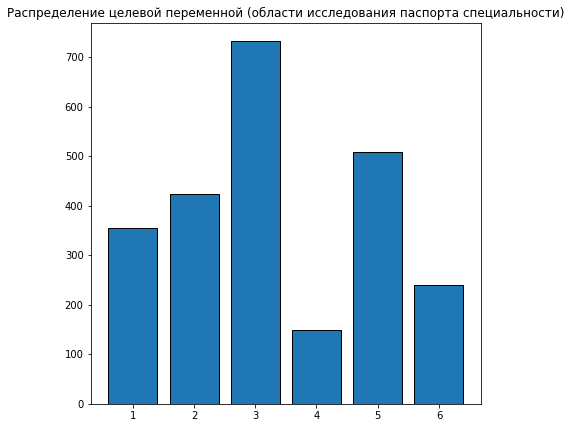

In [31]:
flatten = lambda lst_of_lsts: [elem for lst in lst_of_lsts for elem in lst]
flattened_target = flatten(codes)

from collections import Counter
x = list(zip(*sorted([(k, v) for k, v in dict(Counter(flattened_target)).items()])))
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(x=x[0], height=x[1], edgecolor='k')
ax.set_title('Распределение целевой переменной (области исследования паспорта специальности)')
;

### Значение целевой метрики

In [26]:
from sklearn.metrics import f1_score, jaccard_score

In [27]:
f1 = f1_score(encoded_target, encoded_preds, average='weighted')
print('F1-score:', round(f1, 3))

F1-score (weighted): 0.224


In [28]:
jac = jaccard_score(encoded_target, encoded_preds, average='weighted')
print('Метрика Жаккара:', round(jac, 3))

Метрика Жаккара (weighted): 0.136
